### AE pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = 'drive/My Drive/Colab Notebooks/These/10_gen_models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary

from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

import glob
import pandas as pd
import cv2
import math
from google.colab.patches import cv2_imshow

In [0]:
# Dataset class
class CorrDataset(Dataset):
  def __init__(self, paths_i, paths_q, discr_shape, transform=None):
    '''initialization'''
    self.transform = transform
    #self.labels = labels
    self.paths_i = paths_i
    self.paths_q = paths_q
    self.discr_shape = discr_shape

  def __len__(self):
    '''denotes total number of samples'''
    return len(self.paths_i)

  def __getitem__(self, index):
    '''generates 1 sample of data fromstorage at a time'''
    #print('check index: ', index)
    #print(len(self.paths_i), len(self.paths_q))
    #print('check path: ', self.paths_i[index])
    #print('check path: ', self.paths_q[index])
    # select sample
    path_i = self.paths_i[index]
    path_q = self.paths_q[index]

    # load data and get label
    img_i = cv2.resize(pd.read_csv(path_i, sep=',', header=None).values, self.discr_shape)
    img_q = cv2.resize(pd.read_csv(path_q, sep=',', header=None).values, self.discr_shape)
    img_i = ((img_i - img_i.min()) / (img_i.max() - img_i.min()))[...,None]
    img_q = ((img_q - img_q.min()) / (img_q.max() - img_q.min()))[...,None]
    img = torch.tensor(np.concatenate((img_i, img_q), axis=2))

    #print('check shape before: ', img.shape)
    # transpose images for torch
    img = torch.transpose(img,0,2)
    img = torch.transpose(img,1,2)
    #print('check shape after: ', img.shape)
    return img

torch.Size([2, 28, 28]) 1357


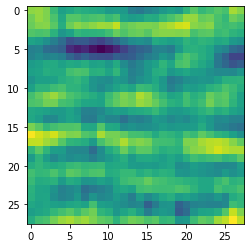

In [4]:
# check SX3 dataset
paths_i = (sorted(glob.glob(data_path + 'data/sx3_data/mp_i/*')) + 
           sorted(glob.glob(data_path + 'data/sx3_data/no_mp_i/*')) + 
           sorted(glob.glob(data_path + 'data/synth_data/mp_i/*')) + 
           sorted(glob.glob(data_path + 'data/synth_data/no_mp_i/*')))

paths_q = (sorted(glob.glob(data_path + 'data/sx3_data/mp_q/*')) + 
           sorted(glob.glob(data_path + 'data/sx3_data/no_mp_q/*')) + 
           sorted(glob.glob(data_path + 'data/synth_data/mp_q/*')) + 
           sorted(glob.glob(data_path + 'data/synth_data/no_mp_q/*')))

dataset = CorrDataset(paths_i, paths_q, (28,28))

# concat subsets
#dataset = ConcatDataset([dataset_mp_sx3, dataset_nomp_sx3, dataset_mp_synth, dataset_nomp_synth])

print(dataset[0].shape, len(dataset))
plt.imshow(dataset[10][0,...].numpy())

---------------

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=3):
  """Helper function to plot a gallery of images"""
  plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
  plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i+1)
    temp = torch.transpose(images[i],0,2)
    temp = torch.transpose(temp,0,1)
    try:
      plt.imshow(temp, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
      plt.xticks(())
      plt.yticks(())
    except:
      pass

In [6]:
# define constants (hard code)
batch_size = 16
TRAIN_SIZE = math.floor(len(dataset) * 0.8)
VAL_SIZE = math.floor(len(dataset) * 0.2)
epochs = 50
print(TRAIN_SIZE, VAL_SIZE)

1085 271


In [0]:
# define transforms
img_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                  #transforms.Normalize(0.5, 0.5)                                    
])

# load mnist dataset
#dataset = MNIST('./data', transform=img_transform, download=True)

# define subset raandom samplers
np.random.seed(0)
indices = np.arange(len(dataset))
np.random.shuffle(indices)

TrainSampler = SubsetRandomSampler(indices[:TRAIN_SIZE])
ValSampler = SubsetRandomSampler(indices[TRAIN_SIZE:])

TrainLoader = DataLoader(dataset, batch_size=batch_size, sampler=TrainSampler)
ValLoader = DataLoader(dataset, batch_size=batch_size, sampler=ValSampler)

In [0]:
#indices.shape, len(TrainLoader.dataset), indices[:TRAIN_SIZE]

In [0]:
# check train loader
print(next(iter(TrainLoader)).shape)
plt.imshow(next(iter(TrainLoader))[0][0])

# check dataset
print(len(dataset), dataset[0][0].shape) #dataset[0][1])

# check dataloader
for batch in TrainLoader:
  print(len(batch), type(batch), batch[0].shape) #batch[1])
  break

# next(iter(dataloader))

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, dimZ):
    super(Autoencoder, self).__init__()
    self.dimZ = dimZ
    # encoder
    self.encoder = nn.Sequential(
        # 28x28x2
        nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16, out_channels=self.dimZ, kernel_size=3, stride=2, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

    # decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=self.dimZ, out_channels=16, kernel_size=3, stride=2),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=3, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    latent_code = self.encoder(x)
    reconstruction = self.decoder(latent_code)
    return reconstruction, latent_code

In [9]:
# latent code dimension
dimZ = 64

# hyper parameters
learning_rate = 1e-4
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
autoencoder = Autoencoder(dimZ).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
summary(autoencoder, (2, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             304
              ReLU-2           [-1, 16, 10, 10]               0
         MaxPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4             [-1, 64, 3, 3]           9,280
              ReLU-5             [-1, 64, 3, 3]               0
         MaxPool2d-6             [-1, 64, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           9,232
              ReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
             ReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
          Sigmoid-12            [-1, 1, 28, 28]               0
Total params: 22,057
Trainable params: 22,057
Non-trainable params: 0
---------------------------------

In [10]:
history = {'loss': [], 'val_loss': []}
i = 0
model_save_path = 'AE_gnss_full_dataset.pth'
min_val_loss = math.inf

# train mathod
for epoch in tqdm_notebook(range(epochs)):
  running_loss = 0
  i = 0
  for batch_img in TrainLoader:
    X_batch = batch_img.to(device).float()

    optimizer.zero_grad()
    reconstr, code = autoencoder(X_batch)
    loss = criterion(reconstr, X_batch)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    i += 1

  batch_val_img = next(iter(ValLoader))
  X_val = batch_val_img.to(device).float()

  reconstr_val, code_val = autoencoder(X_val)
  val_loss = criterion(reconstr_val, X_val)

  history['loss'].append(loss.item())
  history['val_loss'].append(val_loss.item())

  print('epoch: %d / %d, loss %.6f, val_loss: %.6f' % (epoch+1, epochs, running_loss/batch_size/i, val_loss/batch_size))
  print('------------------------------------------')

  # save best model
  if val_loss < min_val_loss:
    torch.save(autoencoder.state_dict(), model_save_path)

  running_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16, 2, 28, 28])) that is different to the input size (torch.Size([16, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([13, 2, 28, 28])) that is different to the input size (torch.Size([13, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1 / 100, loss 0.001827, val_loss: 0.001765
------------------------------------------
epoch: 2 / 100, loss 0.001823, val_loss: 0.001890
------------------------------------------
epoch: 3 / 100, loss 0.001820, val_loss: 0.001737
------------------------------------------
epoch: 4 / 100, loss 0.001815, val_loss: 0.001970
------------------------------------------
epoch: 5 / 100, loss 0.001803, val_loss: 0.001815
------------------------------------------
epoch: 6 / 100, loss 0.001780, val_loss: 0.001603
------------------------------------------
epoch: 7 / 100, loss 0.001737, val_loss: 0.001719
------------------------------------------
epoch: 8 / 100, loss 0.001682, val_loss: 0.001569
------------------------------------------
epoch: 9 / 100, loss 0.001635, val_loss: 0.001529
------------------------------------------
epoch: 10 / 100, loss 0.001600, val_loss: 0.001497
------------------------------------------
epoch: 11 / 100, loss 0.001573, val_loss: 0.001523
------------------

In [0]:
# save model
#torch.save(autoencoder.state_dict(), model_save_path)
#print('modelsaved')

modelsaved


In [0]:
# load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_save_path = data_path + 'models/AE_gnss_full_dataset.pth'
autoencoder = Autoencoder(dimZ)
autoencoder.load_state_dict(torch.load(model_save_path))
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [11]:
# check predictions
with torch.no_grad():
  autoencoder.eval()

  batch_val_img = next(iter(ValLoader))
  X_val = batch_val_img.to(device).float()

  reconstr_val, code_val = autoencoder(X_val)

print(reconstr_val.shape, X_val.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16, 2, 28, 28])


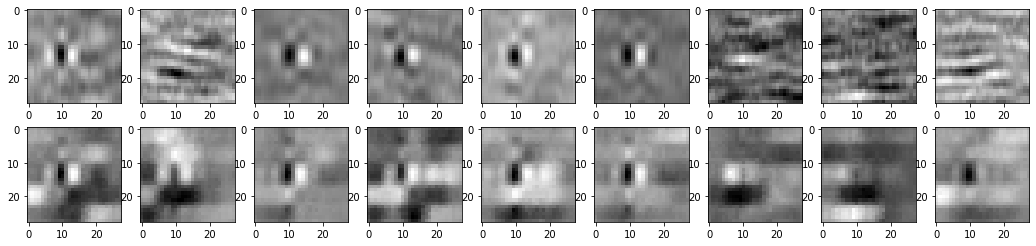

In [12]:
# visualize reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
  # display original
  ax = plt.subplot(2, n, i)
  plt.imshow(X_val[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i+n)
  plt.imshow(reconstr_val[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
plt.show()

### Feature transfer

In [17]:
len(dataset1), len(paths_i_synth)

(608, 608)

In [18]:
# separare pathes to datasets
paths_i_sx3 = (sorted(glob.glob(data_path + 'data/sx3_data/mp_i/*')) + 
           sorted(glob.glob(data_path + 'data/sx3_data/no_mp_i/*')))
paths_q_sx3 = (sorted(glob.glob(data_path + 'data/sx3_data/mp_q/*')) + 
           sorted(glob.glob(data_path + 'data/sx3_data/no_mp_q/*')))

paths_i_synth = (sorted(glob.glob(data_path + 'data/synth_data/mp_i/*')) + 
           sorted(glob.glob(data_path + 'data/synth_data/no_mp_i/*')))
paths_q_synth = (sorted(glob.glob(data_path + 'data/synth_data/mp_q/*')) + 
           sorted(glob.glob(data_path + 'data/synth_data/no_mp_q/*')))

dataset2 = CorrDataset(paths_i_sx3, paths_q_sx3, (28,28))
dataset1 = CorrDataset(paths_i_synth, paths_q_synth, (28,28))

# define transforms
img_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                  #transforms.Normalize(0.5, 0.5)                                    
])

Loader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
Loader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

# get 15 images for dataset1 and dataset2
tensor1 = next(iter(Loader1)).to(device).float()
tensor2 = next(iter(Loader2)).to(device).float()
print(type(tensor1), tensor1.shape, tensor2.shape)

<class 'torch.Tensor'> torch.Size([16, 2, 28, 28]) torch.Size([16, 2, 28, 28])


In [19]:
# compute latent codes for 2 subsets
with torch.no_grad():
  autoencoder.eval()
  code1 = autoencoder.encoder(tensor1)
  code2 = autoencoder.encoder(tensor2)
  
# compute delta vector by substruction of mean of 2 codes
delta_code = torch.mean(code2 - code1, dim=0)
print(code1.shape, code2.shape, delta_code.shape)

torch.Size([16, 64, 2, 2]) torch.Size([16, 64, 2, 2]) torch.Size([64, 2, 2])


In [20]:
# add properties of dataset2 to reconstructed samples of dataset1

# for dataset1 define Loader1
#Loader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=False)

# compute latent code
with torch.no_grad():
  autoencoder.eval()
  batch = next(iter(Loader1))
  X = batch.to(device).float()
  batch_code = autoencoder.encoder(X)
  print(batch_code.shape, type(batch_code))
  
  # add delta_code to the batch_code
  batch_code += delta_code

  # decode images from result batch_code
  outputs = autoencoder.decoder(batch_code)
  print('outptuts shape: ', outputs.shape)

torch.Size([16, 64, 2, 2]) <class 'torch.Tensor'>
outptuts shape:  torch.Size([16, 1, 28, 28])


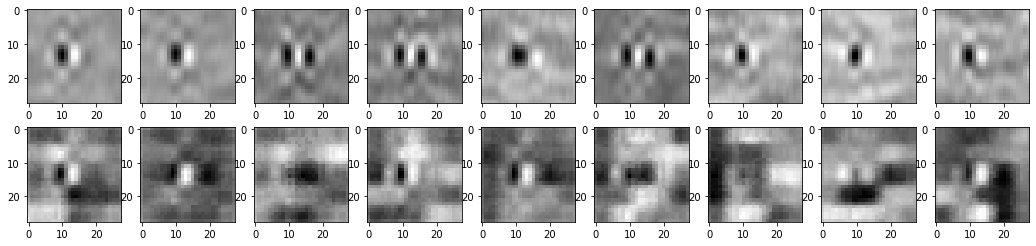

In [21]:
# visualize outputs
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
  # display original
  ax = plt.subplot(2, n, i)
  plt.imshow(X[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i+n)
  plt.imshow(outputs[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
plt.show()